# COVID-19 Worldwide report analysis

Utilizes the daily data reporting from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE):
https://systems.jhu.edu/. This is pulled from time series maintained at Github repo:
https://github.com/CSSEGISandData/COVID-19.  

Using the introductory Data Science Tables (for reference see http://data8.org/datascience/tables.html) of introductory courses.

On 3/23 the timeseries moved and US state level data is no longer present.

In [124]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [125]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Parsing and cleaning
def denan(v):
    return v if v != 'nan' else np.nan

def clean(tbl):
    for lbl in tbl.labels:
        tbl[lbl] = tbl.apply(denan, lbl)

def is_state(name):
    return not ',' in name

def is_county(name):
    return ',' in name

def getstate(name):
    county, state = name.split(', ')
    return state

def getcounty(name):
    county, state = name.split(', ')
    return county

# Tools for working with timestamps
def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, "%m/%d/%y") < datetime.datetime.strptime(day2, "%m/%d/%y")

# Projecting growth rates

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, "%m/%d/%y") + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, "%m/%d/%y")

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, "%m/%d/%y")
    return datetime.datetime.strftime(date, "%m/%d/%y")

def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
        
    day = trend.last('Day')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [126]:
# Tools for working with content
def by_country(raw_world):
    """Aggregate country level data from the raw source"""
    res = raw_world.drop(['Province/State', 'Lat', 'Long']).group('Country/Region', sum)
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

In [127]:
# CSV files for data currated by JHU.
# These changed recently

#confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 

#deathURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
#recoveredURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [128]:
# Raw data of confirmed cases
raw_confirmed = Table.read_table(confirmedURL)
raw_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
nan,Afghanistan,33,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120
nan,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212
nan,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511
nan,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334
nan,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7
nan,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7
nan,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745
nan,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424
Australian Capital Territory,Australia,-35.4735,149.012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77
New South Wales,Australia,-33.8688,151.209,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791


In [129]:
# Aggregate data by country

raw_by_country = by_country(raw_confirmed)

### How many of the 195 recognized countries in the world have reported cases?

This does include some non-countries, like Princess Cruises

In [130]:
raw_by_country.num_rows

177

In [131]:
# Transpose country data to provide timeseries column per country

countries_by_day = TimeTable.transpose(raw_by_country, 'Country/Region', time_col='Day', time_less = less_day)
countries_by_day['Day'] = countries_by_day.apply(format_day, 'Day')
#countries_by_day.take[-7:]

In [132]:
# Change this to truncate data analysys to an earlier date
last_day = countries_by_day.last('Day')
print("last day of data:", last_day)
#last_day = "3/22/20"
countries_by_day = countries_by_day.until(last_day)
countries_by_day.order_cols().take[-10:]

last day of data: 03/29/20


Day,US,Italy,China,Spain,Germany,France,Iran,United Kingdom,Switzerland,Netherlands,Belgium,"Korea, South",Turkey,Austria,Canada,Portugal,Norway,Brazil,Israel,Australia,Sweden,Czechia,Ireland,Denmark,Malaysia,Chile,Luxembourg,Ecuador,Japan,Poland,Romania,Pakistan,Russia,Philippines,Thailand,Saudi Arabia,Indonesia,South Africa,Finland,Greece,India,Iceland,Panama,Dominican Republic,Peru,Mexico,Singapore,Argentina,Serbia,Slovenia,Croatia,Diamond Princess,Colombia,Estonia,Qatar,Egypt,United Arab Emirates,Iraq,New Zealand,Algeria,Bahrain,Morocco,Ukraine,Lithuania,Lebanon,Armenia,Hungary,Latvia,Bulgaria,Andorra,Bosnia and Herzegovina,Costa Rica,Slovakia,Tunisia,Uruguay,Taiwan*,Kazakhstan,Moldova,Jordan,North Macedonia,Kuwait,San Marino,Burkina Faso,Cyprus,Albania,Azerbaijan,Vietnam,Oman,Cote d'Ivoire,Ghana,Malta,Uzbekistan,Senegal,Cameroon,Cuba,Brunei,Afghanistan,Venezuela,Sri Lanka,Nigeria,Honduras,West Bank and Gaza,Mauritius,Cambodia,Belarus,Kosovo,Georgia,Montenegro,Kyrgyzstan,Bolivia,Trinidad and Tobago,Rwanda,Congo (Kinshasa),Paraguay,Liechtenstein,Bangladesh,Monaco,Kenya,Madagascar,Guatemala,Barbados,Uganda,Jamaica,Zambia,Togo,El Salvador,Ethiopia,Congo (Brazzaville),Djibouti,Mali,Niger,Maldives,Guinea,Haiti,Tanzania,Equatorial Guinea,Eritrea,Mongolia,Bahamas,Dominica,Namibia,Burma,Eswatini,Grenada,Saint Lucia,Syria,Guyana,Laos,Libya,Mozambique,Seychelles,Suriname,Angola,Antigua and Barbuda,Gabon,Zimbabwe,Benin,Cabo Verde,Holy See,Sudan,Fiji,Mauritania,Nepal,Bhutan,Gambia,Nicaragua,Central African Republic,Chad,Liberia,Somalia,Belize,Guinea-Bissau,MS Zaandam,Saint Kitts and Nevis,Papua New Guinea,Saint Vincent and the Grenadines,Timor-Leste
03/20/20,19100,47021,81250,20410,19848,12758,19644,4014,5294,3003,2257,8652,359,2388,943,1020,1914,793,529,791,1639,833,683,1337,1030,434,484,367,963,425,308,501,253,230,322,344,369,202,450,495,244,409,137,72,234,164,385,128,135,341,128,712,128,283,470,285,140,208,39,90,285,77,29,49,163,136,85,111,127,75,89,89,137,54,94,135,49,66,85,67,159,144,40,67,70,44,91,48,9,16,64,33,38,20,16,78,24,42,73,12,24,47,12,51,69,0,43,14,6,15,9,17,18,13,28,20,11,7,3,12,5,0,16,2,9,1,9,3,1,0,1,13,1,2,6,6,0,6,3,0,3,0,1,0,2,0,7,0,0,0,7,4,1,1,3,1,2,1,1,2,1,2,1,2,1,1,3,1,2,1,0,0,0,0,1,1,0
03/21/20,25489,53578,81305,25374,22213,14463,20610,5067,6575,3640,2815,8799,670,2814,1277,1280,2118,1021,712,1071,1763,995,785,1420,1183,537,670,506,1007,536,367,730,306,307,411,392,450,240,523,530,330,473,200,112,318,203,432,158,171,383,206,712,196,306,481,294,153,214,52,139,305,96,47,83,187,160,103,124,163,88,93,117,178,60,110,153,53,80,85,85,176,144,64,84,76,53,94,52,14,19,73,43,47,27,21,83,24,70,77,22,24,48,14,53,76,0,49,14,14,19,49,17,23,18,37,25,11,7,3,17,6,1,16,2,16,3,9,3,1,0,1,13,2,2,6,6,1,10,4,0,3,0,1,0,2,0,7,0,0,0,7,4,2,1,4,3,2,3,1,2,1,2,1,2,1,2,3,1,3,1,0,0,0,0,1,1,0
03/22/20,33276,59138,81435,28768,24873,16243,21638,5745,7474,4217,3401,8961,1236,3582,1469,1600,2385,1546,883,1549,1934,1120,906,1514,1306,632,798,789,1101,634,433,776,367,380,599,511,514,274,626,624,396,568,313,202,363,251,455,266,222,414,254,712,231,326,494,327,153,233,102,201,334,115,73,143,248,194,131,139,187,113,126,134,185,75,158,169,60,94,112,115,188,175,75,95,89,65,113,55,14,23,90,43,67,40,35,88,40,70,82,30,26,52,28,84,76,0,54,21,14,24,50,19,30,22,37,27,23,15,3,19,14,1,19,3,16,3,11,3,1,0,2,13,2,2,12,6,1,10,4,1,3,0,4,1,2,1,19,0,0,1,7,5,2,1,5,3,2,3,1,2,2,2,1,2,1,2,3,1,3,1,0,0,0,0,1,1,1
03/23/20,43847,63927,81498,35136,29056,20123,23049,6726,8795,4764,3743,8961,1529,4474,2088,2060,2621,1924,1071,1682,2046,1236,1125,1572,1518,746,875,981,1128,749,576,875,438,462,721,562,579,402,700,695,499,588,345,245,395,316,509,301,249,442,315,712,277,352,501,366,198,266,102,230,377,143,73,179,267,235,167,180,201,133,136,158,186,89,162,195,62,109,127,136,189,187,99,116,104,72,123,66,25,27,107,46,79,56,40,91,40,77,97,40,30,59,36,87,81,0,61,27,16,27,51,36,36,22,51,33,23,16,12,20,17,9,19,3,18,3,11,4,3,0,3,13,4,6,12,9,1,10,4,2,4,0,4,1,3,1,20,0,0,1,7,5,3,3,5,3,5,3,1,2,3,2,2

### Total confirmed cases worldwide

Total confirmed 720117


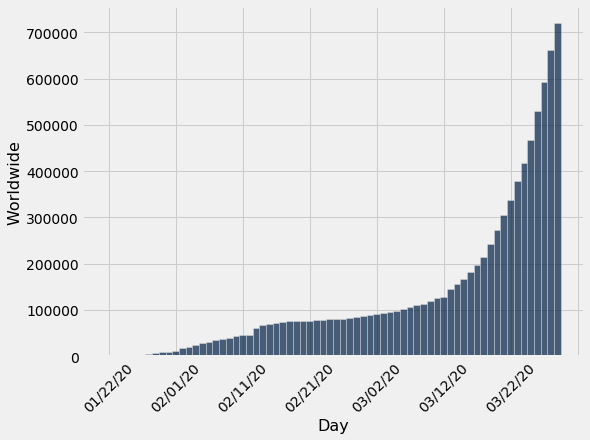

In [133]:
total_confirmed = countries_by_day.select('Day')
total_confirmed['Worldwide'] = countries_by_day.sum_rows()
print('Total confirmed', total_confirmed.last('Worldwide'))
total_confirmed.obar(height=6, width=8)
_ = plots.xticks(rotation=45)

## Global confirmed cases by country - largest

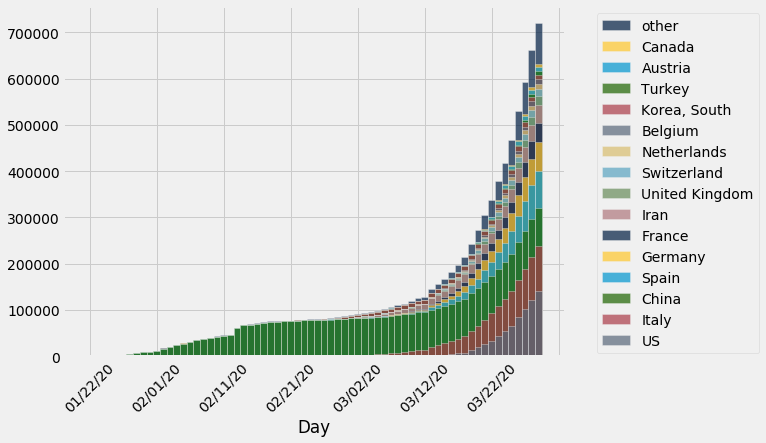

In [134]:
countries_by_day.stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=45)

## Global picture sans China

The global growth rate above is somewhat optimistic, since the growth across the world is amortized over the substantial, but flat, cases in China, now mostly resolved.  Removing that we see a more accurate picture of the trends

In [135]:
# Recent worldwide growth trend - past week
total_confirmed.trend().take[-7:]

Day,Worldwide,new,% new,rate
03/23/20,378235,41282,12.25%,1.12252
03/24/20,418045,39810,10.53%,1.10525
03/25/20,467653,49608,11.87%,1.11867
03/26/20,529591,61938,13.24%,1.13244
03/27/20,593291,63700,12.03%,1.12028
03/28/20,660706,67415,11.36%,1.11363
03/29/20,720117,59411,8.99%,1.08992


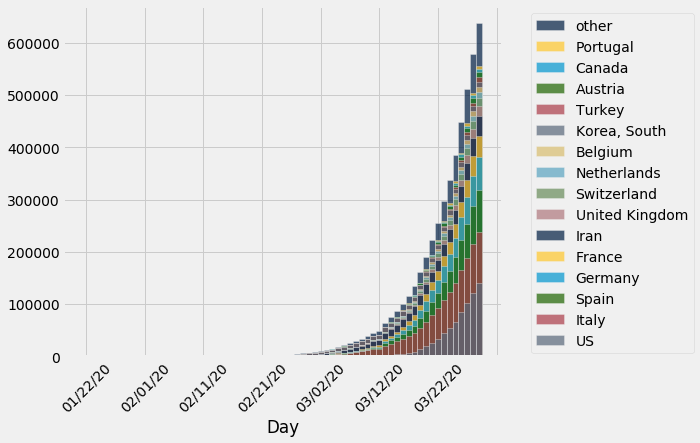

In [136]:
# Taking China out of the picture
sans_china_by_day = countries_by_day.drop('China')
sans_china_by_day.stackbar(15, height=6, width=7)
_ = plots.xticks(rotation=45)

In [137]:
sans_china_confirmed = sans_china_by_day.select('Day')
sans_china_confirmed['Worldwide sans China'] = sans_china_by_day.sum_rows()
sans_china_confirmed.trend().take[-15:].show()

Day,Worldwide sans China,new,% new,rate
03/15/20,86451,11327,15.08%,1.15078
03/16/20,100541,14090,16.30%,1.16298
03/17/20,116044,15503,15.42%,1.1542
03/18/20,133719,17675,15.23%,1.15231
03/19/20,161344,27625,20.66%,1.20659
03/20/20,190785,29441,18.25%,1.18247
03/21/20,223091,32306,16.93%,1.16933
03/22/20,255518,32427,14.54%,1.14535
03/23/20,296737,41219,16.13%,1.16132
03/24/20,336454,39717,13.38%,1.13385


## Projecting global trends two weeks out

The following indicates confirmed cases for the two weeks ahead.

In [138]:
project_trend(total_confirmed.trend().take[-7:], 14).show()

Day,Worldwide,new,% new,rate
03/23/20,378235,41282,0.122516,1.12252
03/24/20,418045,39810,0.105252,1.10525
03/25/20,467653,49608,0.118667,1.11867
03/26/20,529591,61938,0.132444,1.13244
03/27/20,593291,63700,0.120282,1.12028
03/28/20,660706,67415,0.113629,1.11363
03/29/20,720117,59411,0.0899205,1.08992
03/30/20,786299,66182,0.084169,1.11396
03/31/20,860023,73724,0.0857233,1.11396
04/01/20,942149,82126,0.0871688,1.11396


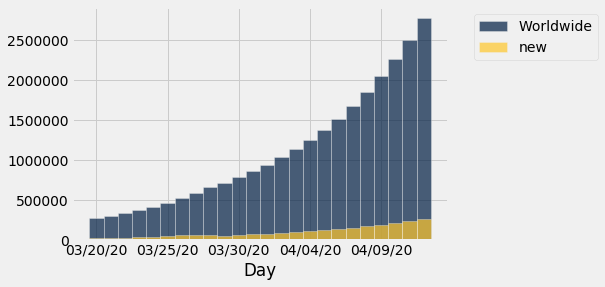

In [139]:
proj = project_trend(total_confirmed.trend().take[-10:], 14).select(['Day', 'Worldwide', 'new'])
proj.bar('Day')

Assuming China stays flat and using the growth rate of the rest of the world, we get a more concerning picture.

In [140]:
project_trend(sans_china_confirmed.trend().take[-10:], 14).show()

Day,Worldwide sans China,new,% new,rate
03/20/20,190785,29441,0.182473,1.18247
03/21/20,223091,32306,0.169332,1.16933
03/22/20,255518,32427,0.145353,1.14535
03/23/20,296737,41219,0.161315,1.16132
03/24/20,336454,39717,0.133846,1.13385
03/25/20,385992,49538,0.147236,1.14724
03/26/20,447809,61817,0.160151,1.16015
03/27/20,511394,63585,0.141991,1.14199
03/28/20,578707,67313,0.131626,1.13163
03/29/20,637995,59288,0.102449,1.10245


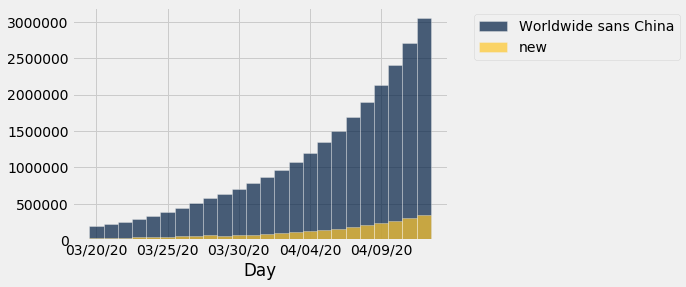

In [141]:
proj = project_trend(sans_china_confirmed.trend().take[-10:], 14).select(range(3))
proj.bar('Day')

# Country level trends

Recent confirmed cases on a country by country basis.

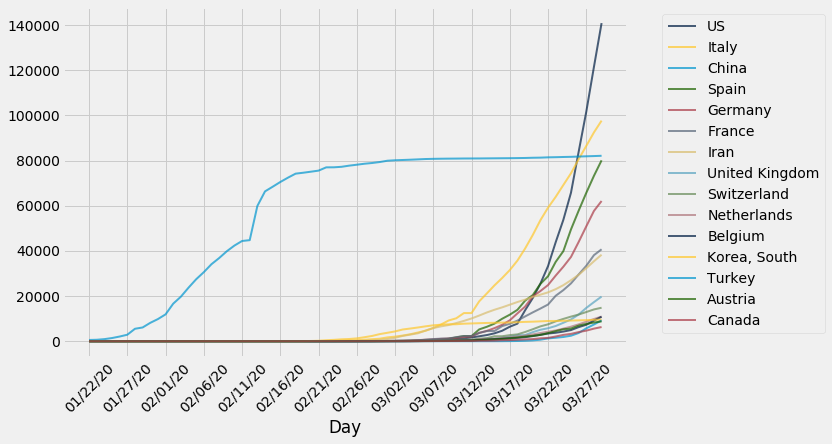

In [142]:
countries_by_day.top(15).oplot(height=6, width=9)
xs = countries_by_day['Day']
_ = plots.xticks(xs[range(0, len(xs), 5)], rotation=45)

In [143]:
def cases_since(cases, threshold=100, width=6, height=6):
    _, axis = plots.subplots(figsize=(width, height))
    for region in cases.categories :
        ctbl = cases.extract(region)
        since = ctbl.where(ctbl[region] >= threshold)
        ndays = since.num_rows
        vals = since[region]
        axis.plot(vals)
        axis.text(ndays-1, vals[-1], region)

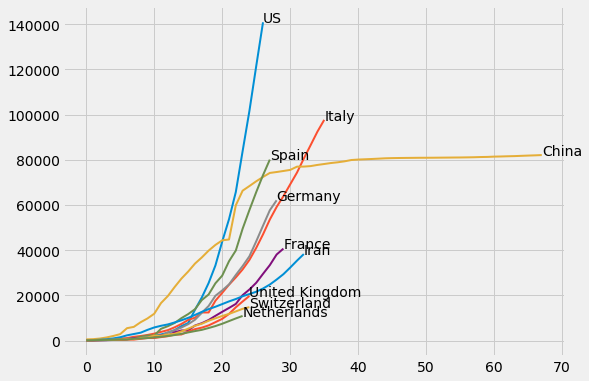

In [144]:
cases_since(countries_by_day.top(10), width=8)

In [145]:
countries_by_day.top(15).take[-10:]

Day,US,Italy,China,Spain,Germany,France,Iran,United Kingdom,Switzerland,Netherlands,Belgium,"Korea, South",Turkey,Austria,Canada
03/20/20,19100,47021,81250,20410,19848,12758,19644,4014,5294,3003,2257,8652,359,2388,943
03/21/20,25489,53578,81305,25374,22213,14463,20610,5067,6575,3640,2815,8799,670,2814,1277
03/22/20,33276,59138,81435,28768,24873,16243,21638,5745,7474,4217,3401,8961,1236,3582,1469
03/23/20,43847,63927,81498,35136,29056,20123,23049,6726,8795,4764,3743,8961,1529,4474,2088
03/24/20,53740,69176,81591,39885,32986,22622,24811,8164,9877,5580,4269,9037,1872,5283,2790
03/25/20,65778,74386,81661,49515,37323,25600,27017,9640,10897,6438,4937,9137,2433,5588,3251
03/26/20,83836,80589,81782,57786,43938,29551,29406,11812,11811,7468,6235,9241,3629,6909,4042
03/27/20,101657,86498,81897,65719,50871,33402,32332,14745,12928,8647,7284,9332,5698,7657,4682
03/28/20,121478,92472,81999,73235,57695,38105,35408,17312,14076,9819,9134,9478,7402,8271,5576
03/29/20,140886,97689,82122,80110,62095,40708,38309,19780,14829,10930,10836,9583,9217,8788,6280


In [146]:
countries_by_day.top(15).trend().take[-10:]

Day,US,new US,% newUS,rate US,Italy,new Italy,% newItaly,rate Italy,China,new China,% newChina,rate China,Spain,new Spain,% newSpain,rate Spain,Germany,new Germany,% newGermany,rate Germany,France,new France,% newFrance,rate France,Iran,new Iran,% newIran,rate Iran,United Kingdom,new United Kingdom,% newUnited Kingdom,rate United Kingdom,Switzerland,new Switzerland,% newSwitzerland,rate Switzerland,Netherlands,new Netherlands,% newNetherlands,rate Netherlands,Belgium,new Belgium,% newBelgium,rate Belgium,"Korea, South","new Korea, South","% newKorea, South","rate Korea, South",Turkey,new Turkey,% newTurkey,rate Turkey,Austria,new Austria,% newAustria,rate Austria,Canada,new Canada,% newCanada,rate Canada
03/20/20,19100,5423,28.39%,1.39651,47021,5986,12.73%,1.14588,81250,94,0.12%,1.00116,20410,2447,11.99%,1.13622,19848,4528,22.81%,1.29556,12758,1788,14.01%,1.16299,19644,1237,6.30%,1.0672,4014,1298,32.34%,1.47791,5294,1219,23.03%,1.29914,3003,536,17.85%,1.21727,2257,462,20.47%,1.25738,8652,87,1.01%,1.01016,359,167,46.52%,1.86979,2388,375,15.70%,1.18629,943,143,15.16%,1.17875
03/21/20,25489,6389,25.07%,1.3345,53578,6557,12.24%,1.13945,81305,55,0.07%,1.00068,25374,4964,19.56%,1.24321,22213,2365,10.65%,1.11916,14463,1705,11.79%,1.13364,20610,966,4.69%,1.04918,5067,1053,20.78%,1.26233,6575,1281,19.48%,1.24197,3640,637,17.50%,1.21212,2815,558,19.82%,1.24723,8799,147,1.67%,1.01699,670,311,46.42%,1.8663,2814,426,15.14%,1.17839,1277,334,26.16%,1.35419
03/22/20,33276,7787,23.40%,1.3055,59138,5560,9.40%,1.10377,81435,130,0.16%,1.0016,28768,3394,11.80%,1.13376,24873,2660,10.69%,1.11975,16243,1780,10.96%,1.12307,21638,1028,4.75%,1.04988,5745,678,11.80%,1.13381,7474,899,12.03%,1.13673,4217,577,13.68%,1.15852,3401,586,17.23%,1.20817,8961,162,1.81%,1.01841,1236,566,45.79%,1.84478,3582,768,21.44%,1.27292,1469,192,13.07%,1.15035
03/23/20,43847,10571,24.11%,1.31768,63927,4789,7.49%,1.08098,81498,63,0.08%,1.00077,35136,6368,18.12%,1.22136,29056,4183,14.40%,1.16817,20123,3880,19.28%,1.23887,23049,1411,6.12%,1.06521,6726,981,14.59%,1.17076,8795,1321,15.02%,1.17675,4764,547,11.48%,1.12971,3743,342,9.14%,1.10056,8961,0,0.00%,1,1529,293,19.16%,1.23706,4474,892,19.94%,1.24902,2088,619,29.65%,1.42138
03/24/20,53740,9893,18.41%,1.22563,69176,5249,7.59%,1.08211,81591,93,0.11%,1.00114,39885,4749,11.91%,1.13516,32986,3930,11.91%,1.13526,22622,2499,11.05%,1.12419,24811,1762,7.10%,1.07645,8164,1438,17.61%,1.2138,9877,1082,10.95%,1.12302,5580,816,14.62%,1.17128,4269,526,12.32%,1.14053,9037,76,0.84%,1.00848,1872,343,18.32%,1.22433,5283,809,15.31%,1.18082,2790,702,25.16%,1.33621
03/25/20,65778,12038,18.30%,1.224,74386,5210,7.00%,1.07532,81661,70,0.09%,1.00086,49515,9630,19.45%,1.24144,37323,4337,11.62%,1.13148,25600,2978,11.63%,1.13164,27017,2206,8.17%,1.08891,9640,1476,15.31%,1.18079,10897,1020,9.36%,1.10327,6438,858,13.33%,1.15376,4937,668,13.53%,1.15648,9137,100,1.09%,1.01107,2433,561,23.06%,1.29968,5588,305,5.46%,1.05773,3251,461,14.18%,1.16523
03/26/20,83836,18058,21.54%,1.27453,80589,6203,7.70%,1.08339,81782,121,0.15%,1.00148,57786,8271,14.31%,1.16704,43938,6615,15.06%,1.17724,29551,3951,13.37%,1.15434,29406,2389,8.12%,1.08843,11812,2172,18.39%,1.22531,11811,914,7.74%,1.08388,7468,1030,13.79%,1.15999,6235,1298,20.82%,1.26291,9241,104,1.13%,1.01138,3629,1196,32.96%,1.49157,6909,1321,19.12%,1.2364,4042,791,19.57%,1.24331
03/27/20,101657,17821,17.53%,1.21257,86498,5909,6.83%,1.07332,81897,115,0.14%,1.00141,65719,7933,12.07%,1.13728,50871,6933,13.63%,1.15779,33402,3851,11.53%,1.13032,32332,2926,9.05%,1.0995,14745,2933,19.89%,1.24831,12928,1117,8.64%,1.09457,8647,1179,13.63%,1.15787,7284,1049,14.40%,1.16824,9332,91,0.98%,1.00985,5698,2069,36.31%,1.57013,7657,748,9.77%,1.10826,4682,640,13.67%,1.15834
03/28/20,121478,19821,16.32%,1.19498,92472,5974,6.46%,1.06907,81999,102,0.12%,1.00125,73235,7516,10.26%,1.11437,57695,6824,11.83%,1.13414,38105,4703,12.34%,1.1408,35408,3076,8.69%,1.09514,17312,2567,14.83%,1.17409,14076,1148,8.16%,1.0888,9819,1172,11.94%,1.13554,9134

In [147]:
def project_one(country, back, forward):
    return project_trend(countries_by_day.extract(country).take[-back:].trend(), forward).select('Day', country)

def project_all(back, forward):
    projs = project_one(countries_by_day.categories[0], back, forward)
    for country in countries_by_day.categories[1:] :
        try :
            proj = project_one(country, back, forward)
            if not np.isnan(proj.last(country)) :
                projs[country] = proj[country]
        except :
            print('skip', country)
    return projs

In [149]:
ww_projection = project_all(7, 14).order_cols()
ww_projection['Day'] = ww_projection.apply(format_day, 'Day')
ww_projection.show()

Day,US,Turkey,Spain,Germany,Italy,United Kingdom,Belgium,France,Iran,China,Netherlands,Portugal,Canada,Israel,Switzerland,Philippines,Ukraine,Austria,Russia,Romania,Brazil,Australia,Kazakhstan,Libya,Chile,Poland,Dominican Republic,Norway,Sweden,"Korea, South",Ireland,Czechia,Congo (Brazzaville),Mexico,Peru,Grenada,Panama,Denmark,New Zealand,Japan,Malaysia,Indonesia,Morocco,Ecuador,South Africa,Thailand,Luxembourg,Serbia,United Arab Emirates,Pakistan,Cote d'Ivoire,Uzbekistan,Saudi Arabia,Argentina,Greece,Bosnia and Herzegovina,Colombia,Hungary,Guinea,Finland,Lithuania,Honduras,Algeria,Croatia,Cameroon,Iceland,Azerbaijan,India,Cuba,Estonia,Iraq,Tunisia,Slovenia,Nigeria,Singapore,Latvia,Moldova,Andorra,Kyrgyzstan,Cyprus,Qatar,Uruguay,Egypt,Eritrea,Saint Lucia,Lebanon,Armenia,Madagascar,Niger,Slovakia,Costa Rica,Bolivia,Bahrain,North Macedonia,Oman,Bulgaria,Burkina Faso,Kuwait,El Salvador,Diamond Princess,Jordan,West Bank and Gaza,Albania,Taiwan*,Ghana,Mauritius,Vietnam,Rwanda,Senegal,Haiti,Afghanistan,Barbados,Uganda,Ethiopia,Syria,San Marino,Brunei,Djibouti,Malta,Sri Lanka,Cambodia,Kosovo,Trinidad and Tobago,Venezuela,Georgia,Monaco,Paraguay,Montenegro,Kenya,Belarus,Congo (Kinshasa),Jamaica,Liechtenstein,Namibia,Bangladesh,Zambia,Burma,Angola,Guatemala,Maldives,Bahamas,Togo,Cabo Verde,Sudan,Bhutan,Gambia,Mali,Tanzania,Equatorial Guinea,Mongolia,Dominica,Eswatini,Guyana,Laos,Mozambique,Seychelles,Suriname,Antigua and Barbuda,Gabon,Zimbabwe,Benin,Holy See,Fiji,Mauritania,Nepal,Nicaragua,Central African Republic,Chad,Liberia,Somalia,Belize,Guinea-Bissau,MS Zaandam,Saint Kitts and Nevis,Papua New Guinea,Saint Vincent and the Grenadines,Timor-Leste
03/23/20,43847,1529,35136,29056,63927,6726,3743,20123,23049,81498,4764,2060,2088,1071,8795,462,73,4474,438,576,1924,1682,62,0,746,749,245,2621,2046,8961,1125,1236,4,316,395,1,345,1572,102,1128,1518,579,143,981,402,721,875,249,198,875,25,46,562,301,695,136,277,167,4,700,179,30,230,315,56,588,72,499,40,352,266,89,442,40,509,180,109,133,16,116,501,162,366,1,3,267,235,12,3,186,158,27,377,136,66,201,99,189,3,712,127,59,104,195,27,36,123,36,79,6,40,17,9,11,1,187,91,3,107,97,87,0,51,77,61,23,22,27,16,81,36,19,51,4,33,3,0,3,20,13,4,18,3,2,2,2,0,12,9,10,2,4,20,0,1,7,5,3,5,3,5,1,3,2,2,2,3,1,3,1,1,0,0,0,1,1,1
03/24/20,53740,1872,39885,32986,69176,8164,4269,22622,24811,81591,5580,2362,2790,1238,9877,552,97,5283,495,794,2247,2044,72,1,922,901,312,2863,2286,9037,1329,1394,4,367,416,1,345,1718,155,1193,1624,686,170,1082,554,827,1099,303,248,972,73,50,767,387,743,166,378,187,4,792,209,30,264,382,66,648,87,536,48,369,316,114,480,44,558,197,125,164,42,124,526,162,402,1,3,318,249,17,3,204,177,29,392,148,84,218,114,191,5,712,154,59,123,215,53,42,134,40,86,7,74,18,9,12,1,187,104,3,110,102,91,0,57,84,70,23,27,47,25,81,45,21,51,7,39,3,0,3,21,13,5,20,3,3,2,3,0,12,9,10,2,4,5,2,3,7,7,3,6,3,6,4,4,2,2,2,3,3,3,1,1,0,0,0,1,1,1
03/25/20,65778,2433,49515,37323,74386,9640,4937,25600,27017,81661,6438,2995,3251,2369,10897,636,145,5588,658,906,2554,2364,81,1,1142,1051,392,3084,2526,9137,1564,1654,4,405,480,1,443,1862,205,1307,1796,790,225,1173,709,934,1333,384,333,1063,80,60,900,387,821,176,470,226,4,880,274,36,302,442,75,737,93,657,57,404,346,173,528,51,631,221,149,188,44,132,537,189,456,4,3,333,265,19,7,216,201,32,419,177,99,242,146,195,9,712,172,59,146,235,93,48,141,41,99,8,84,18,14,12,5,208,109,11,129,102,96,0,60,91,75,31,37,52,28,86,48,26,51,7,39,12,0,3,24,13,5,23,4,3,2,3,2,12,9,10,7,4,5,3,5,7,8,3,6,3,6,4,5,2,3,2,3,3,3,1,2,2,0,2,1,1,1
03/26/20,83836,3629,57786,43938,80589,11812,6235,29551,29406,81782,7468,3544,4042,2693,11811,707,196,6909,840,1029,2985,2810,111,1,1306,1221,488,3369,2840,9241,1819,1925,4,475,580,7,558,2023,283,1387,2031,893,275,1403,927,1045,1453,384,333,1201,96,75,1012,502,892,191,491,261,4,958,299,52,367,495,75,802,122,727,67,538,382,197,562,65,683,244,177,224,44,146,549,217,495,6,3,368,290,23,10,226,231,43,458,201,109,264,152,208,13,712,212,84,174,252,132,81,153,50,105,8,94,18,14,12,5,208,114,11,134,1

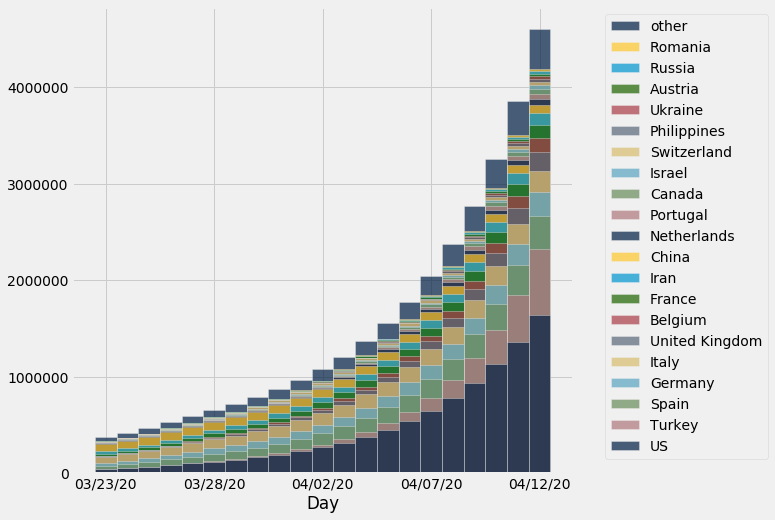

In [150]:
ww_projection.stackbar(20, height=8, width=8)

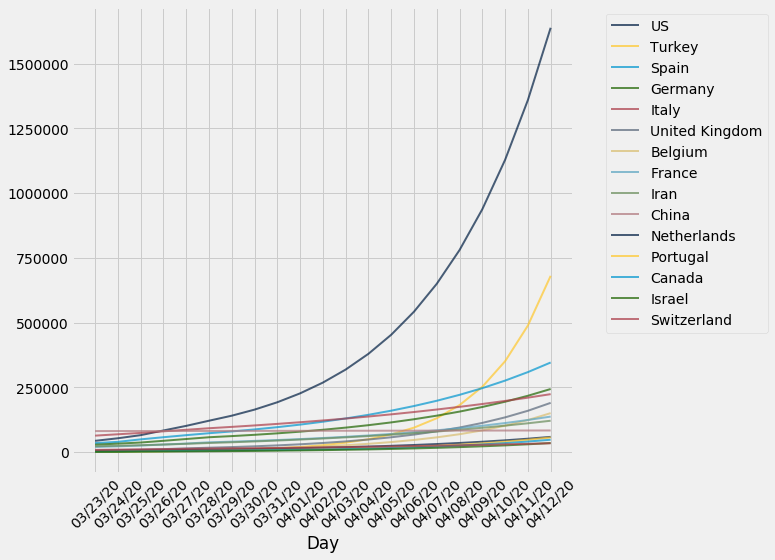

In [151]:
ww_projection.top(15).oplot(height=8, width=8)
_ = plots.xticks(rotation=45)

In [152]:
countries_by_day.top(10).take[-7:]

Day,US,Italy,China,Spain,Germany,France,Iran,United Kingdom,Switzerland,Netherlands
03/23/20,43847,63927,81498,35136,29056,20123,23049,6726,8795,4764
03/24/20,53740,69176,81591,39885,32986,22622,24811,8164,9877,5580
03/25/20,65778,74386,81661,49515,37323,25600,27017,9640,10897,6438
03/26/20,83836,80589,81782,57786,43938,29551,29406,11812,11811,7468
03/27/20,101657,86498,81897,65719,50871,33402,32332,14745,12928,8647
03/28/20,121478,92472,81999,73235,57695,38105,35408,17312,14076,9819
03/29/20,140886,97689,82122,80110,62095,40708,38309,19780,14829,10930


In [153]:
final_trend = countries_by_day.trend().take[-1:]
final_trend

Day,Afghanistan,new Afghanistan,% newAfghanistan,rate Afghanistan,Albania,new Albania,% newAlbania,rate Albania,Algeria,new Algeria,% newAlgeria,rate Algeria,Andorra,new Andorra,% newAndorra,rate Andorra,Angola,new Angola,% newAngola,rate Angola,Antigua and Barbuda,new Antigua and Barbuda,% newAntigua and Barbuda,rate Antigua and Barbuda,Argentina,new Argentina,% newArgentina,rate Argentina,Armenia,new Armenia,% newArmenia,rate Armenia,Australia,new Australia,% newAustralia,rate Australia,Austria,new Austria,% newAustria,rate Austria,Azerbaijan,new Azerbaijan,% newAzerbaijan,rate Azerbaijan,Bahamas,new Bahamas,% newBahamas,rate Bahamas,Bahrain,new Bahrain,% newBahrain,rate Bahrain,Bangladesh,new Bangladesh,% newBangladesh,rate Bangladesh,Barbados,new Barbados,% newBarbados,rate Barbados,Belarus,new Belarus,% newBelarus,rate Belarus,Belgium,new Belgium,% newBelgium,rate Belgium,Belize,new Belize,% newBelize,rate Belize,Benin,new Benin,% newBenin,rate Benin,Bhutan,new Bhutan,% newBhutan,rate Bhutan,Bolivia,new Bolivia,% newBolivia,rate Bolivia,Bosnia and Herzegovina,new Bosnia and Herzegovina,% newBosnia and Herzegovina,rate Bosnia and Herzegovina,Brazil,new Brazil,% newBrazil,rate Brazil,Brunei,new Brunei,% newBrunei,rate Brunei,Bulgaria,new Bulgaria,% newBulgaria,rate Bulgaria,Burkina Faso,new Burkina Faso,% newBurkina Faso,rate Burkina Faso,Burma,new Burma,% newBurma,rate Burma,Cabo Verde,new Cabo Verde,% newCabo Verde,rate Cabo Verde,Cambodia,new Cambodia,% newCambodia,rate Cambodia,Cameroon,new Cameroon,% newCameroon,rate Cameroon,Canada,new Canada,% newCanada,rate Canada,Central African Republic,new Central African Republic,% newCentral African Republic,rate Central African Republic,Chad,new Chad,% newChad,rate Chad,Chile,new Chile,% newChile,rate Chile,China,new China,% newChina,rate China,Colombia,new Colombia,% newColombia,rate Colombia,Congo (Brazzaville),new Congo (Brazzaville),% newCongo (Brazzaville),rate Congo (Brazzaville),Congo (Kinshasa),new Congo (Kinshasa),% newCongo (Kinshasa),rate Congo (Kinshasa),Costa Rica,new Costa Rica,% newCosta Rica,rate Costa Rica,Cote d'Ivoire,new Cote d'Ivoire,% newCote d'Ivoire,rate Cote d'Ivoire,Croatia,new Croatia,% newCroatia,rate Croatia,Cuba,new Cuba,% newCuba,rate Cuba,Cyprus,new Cyprus,% newCyprus,rate Cyprus,Czechia,new Czechia,% newCzechia,rate Czechia,Denmark,new Denmark,% newDenmark,rate Denmark,Diamond Princess,new Diamond Princess,% newDiamond Princess,rate Diamond Princess,Djibouti,new Djibouti,% newDjibouti,rate Djibouti,Dominica,new Dominica,% newDominica,rate Dominica,Dominican Republic,new Dominican Republic,% newDominican Republic,rate Dominican Republic,Ecuador,new Ecuador,% newEcuador,rate Ecuador,Egypt,new Egypt,% newEgypt,rate Egypt,El Salvador,new El Salvador,% newEl Salvador,rate El Salvador,Equatorial Guinea,new Equatorial Guinea,% newEquatorial Guinea,rate Equatorial Guinea,Eritrea,new Eritrea,% newEritrea,rate Eritrea,Estonia,new Estonia,% newEstonia,rate Estonia,Eswatini,new Eswatini,% newEswatini,rate Eswatini,Ethiopia,new Ethiopia,% newEthiopia,rate Ethiopia,Fiji,new Fiji,% newFiji,rate Fiji,Finland,new Finland,% newFinland,rate Finland,France,new France,% newFrance,rate France,Gabon,new Gabon,% newGabon,rate Gabon,Gambia,new Gambia,% newGambia,rate Gambia,Georgia,new Georgia,% newGeorgia,rate Georgia,Germany,new Germany,% newGermany,rate Germany,Ghana,new Ghana,% newGhana,rate Ghana,Greece,new Greece,% newGreece,rate Greece,Grenada,new Grenada,% newGrenada,rate Grenada,Guatemala,new Guatemala,% newGuatemala,rate Guatemala,Guinea,new Guinea,% newGuinea,rate Guinea,Guinea-Bissau,new Guinea-Bissau,% newGuinea-Bissau,rate Guinea-Bissau,Guyana,new Guyana,% newGuyana,rate Guyana,Haiti,new Haiti,% newHaiti,rate Haiti,Holy See,new Holy See,% newHoly See,rate Holy See,Honduras,new Honduras,% newHonduras,rate Honduras,Hungary,new Hungary,% newHungary,rate Hungary,Iceland,new Iceland,% newIceland,rate Iceland,India,new India,% newIndia,rate India,Indonesia,new 

In [154]:
def countries(raw_world):
    """Country level metadata from the raw source"""
    res = raw_world.select(['Country/Region', 'Lat', 'Long']).group('Country/Region', np.mean)
    return res

def get_new(trend, country):
    return trend['new ' + country][-1]

def get_rate(trend, country):
    return trend['rate ' + country][-1]

In [155]:
raw_by_country

Country/Region,01/22/20,01/23/20,01/24/20,01/25/20,01/26/20,01/27/20,01/28/20,01/29/20,01/30/20,01/31/20,02/01/20,02/02/20,02/03/20,02/04/20,02/05/20,02/06/20,02/07/20,02/08/20,02/09/20,02/10/20,02/11/20,02/12/20,02/13/20,02/14/20,02/15/20,02/16/20,02/17/20,02/18/20,02/19/20,02/20/20,02/21/20,02/22/20,02/23/20,02/24/20,02/25/20,02/26/20,02/27/20,02/28/20,02/29/20,03/01/20,03/02/20,03/03/20,03/04/20,03/05/20,03/06/20,03/07/20,03/08/20,03/09/20,03/10/20,03/11/20,03/12/20,03/13/20,03/14/20,03/15/20,03/16/20,03/17/20,03/18/20,03/19/20,03/20/20,03/21/20,03/22/20,03/23/20,03/24/20,03/25/20,03/26/20,03/27/20,03/28/20,03/29/20
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7
Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745
Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424
Australia,0,0,0,0,4,5,5,6,9,9,12,12,12,13,13,14,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,25,27,30,39,52,55,60,63,76,91,107,128,128,200,250,297,377,452,568,681,791,1071,1549,1682,2044,2364,2810,3143,3640,3984
Austria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,9,14,18,21,29,41,55,79,104,131,182,246,302,504,655,860,1018,1332,1646,2013,2388,2814,3582,4474,5283,5588,6909,7657,8271,8788


In [156]:
days = countries_by_day.num_rows
country_summary = countries(raw_confirmed).join('Country/Region', raw_by_country.select(['Country/Region', last_day]))
country_summary['new'] = country_summary.apply(lambda c: get_new(final_trend, c), 'Country/Region')
country_summary['growth'] = country_summary['new'] / country_summary[last_day]
country_summary['rate'] = country_summary.apply(lambda c: get_rate(final_trend, c), 'Country/Region')
country_summary['days'] = country_summary.apply(lambda c: days - np.count_nonzero(countries_by_day[c] < 5), 'Country/Region')

In [157]:
country_summary.sort('rate', descending=True).show()

Country/Region,Lat mean,Long mean,03/29/20,new,growth,rate,days
Congo (Brazzaville),-4.0383,21.7587,19,15,0.789474,4.75,1
Saint Lucia,13.9094,-60.9789,9,6,0.666667,3,1
Libya,26.3351,17.2283,8,5,0.625,2.66667,1
Guinea,9.9456,-9.6966,16,8,0.5,2,3
Eritrea,15.1794,39.7823,12,6,0.5,2,4
Haiti,18.9712,-72.2852,15,7,0.466667,1.875,7
Syria,34.8021,38.9968,9,4,0.444444,1.8,5
Niger,17.6078,8.0817,18,8,0.444444,1.8,5
Cote d'Ivoire,7.54,-5.5471,165,64,0.387879,1.63366,13
Cameroon,3.848,11.5021,139,48,0.345324,1.52747,13


In [158]:
def label_point(country, x, y):
    t = country_summary.where('Country/Region', country)
    plots.text(t[x][0], t[y], country)

## Growth rate versus number of confirmed cases

A greast deal of attention is focused on the countries with the largest number of confirmed cases.  But that mostly refects the the time since community transmission started.  We should be paying more attention to growth rates.  That paints a very different picture.  The large infected population is increasing around 10% per day.  But many of the countries that are earlier in the process are growing incredibly quickly.

In [159]:
largest_cases = country_summary.sort(last_day, descending=True).take[:8]
largest_cases

Country/Region,Lat mean,Long mean,03/29/20,new,growth,rate,days
US,37.0902,-95.7129,140886,19408,0.137757,1.15977,64
Italy,43,12,97689,5217,0.0534042,1.05642,38
China,32.8284,111.649,82122,123,0.00149777,1.0015,68
Spain,40,-4,80110,6875,0.0858195,1.09388,34
Germany,51,9,62095,4400,0.0708592,1.07626,59
France,4.44772,11.6035,40708,2603,0.0639432,1.06831,61
Iran,32,53,38309,2901,0.0757263,1.08193,39
United Kingdom,32.1826,-42.3401,19780,2468,0.124772,1.14256,49


In [160]:
largest_growth = country_summary.sort('growth', descending=True).take[:10]
largest_growth

Country/Region,Lat mean,Long mean,03/29/20,new,growth,rate,days
Congo (Brazzaville),-4.0383,21.7587,19,15,0.789474,4.75,1
Saint Lucia,13.9094,-60.9789,9,6,0.666667,3,1
Libya,26.3351,17.2283,8,5,0.625,2.66667,1
Guinea,9.9456,-9.6966,16,8,0.5,2,3
Eritrea,15.1794,39.7823,12,6,0.5,2,4
Haiti,18.9712,-72.2852,15,7,0.466667,1.875,7
Syria,34.8021,38.9968,9,4,0.444444,1.8,5
Niger,17.6078,8.0817,18,8,0.444444,1.8,5
Cote d'Ivoire,7.54,-5.5471,165,64,0.387879,1.63366,13
Cameroon,3.848,11.5021,139,48,0.345324,1.52747,13


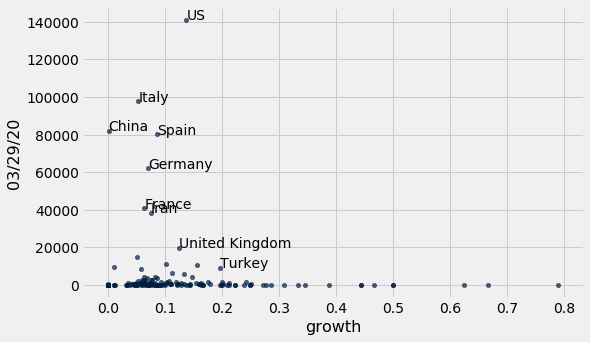

In [161]:
country_summary.where(country_summary['growth']>=0).select([last_day, 'growth']).scatter('growth', width=8)
for c in largest_cases['Country/Region']:
    label_point(c, 'growth', last_day)
label_point('Turkey', 'growth', last_day)

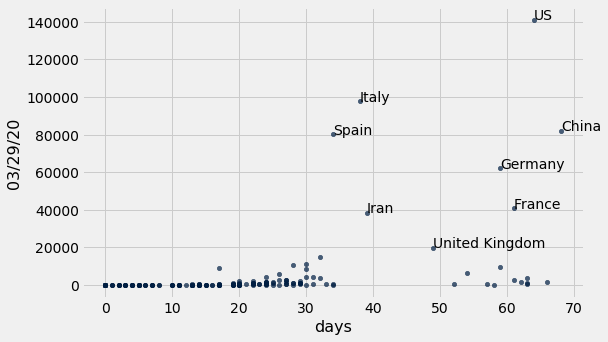

In [162]:
country_summary.select([last_day, 'days']).scatter('days', width=8)
for c in largest_cases['Country/Region']:
    label_point(c, 'days', last_day)

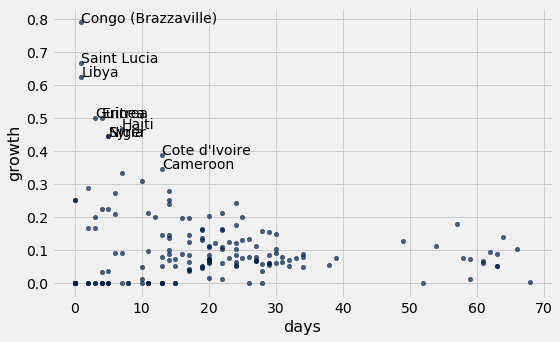

In [163]:
country_summary.select(['growth', 'days']).scatter('days', width=8)
for c in largest_growth['Country/Region']:
    label_point(c, 'days', 'growth')

In [164]:
country_summary.sort('days', descending=True).take[:15].show()

Country/Region,Lat mean,Long mean,03/29/20,new,growth,rate,days
China,32.8284,111.649,82122,123,0.00149777,1.0015,68
Thailand,15,101,1388,143,0.103026,1.11486,66
US,37.0902,-95.7129,140886,19408,0.137757,1.15977,64
Taiwan*,23.7,121,298,15,0.0503356,1.053,63
Singapore,1.2833,103.833,844,42,0.049763,1.05237,63
Australia,-31.9962,141.233,3984,344,0.0863454,1.09451,63
Japan,36,138,1866,173,0.0927117,1.10219,62
Malaysia,2.5,112.5,2470,150,0.0607287,1.06466,61
France,4.44772,11.6035,40708,2603,0.0639432,1.06831,61
"Korea, South",36,128,9583,105,0.0109569,1.01108,59


## Will warmer seasons help?  What about lower lattitudes?

Much has been said about warmer weather reducing the spread.  Some have suggested that southern hemisphere or lower latitudes are harbingers of how that might develop.  We can look at confirmed cases and growth by latitude.


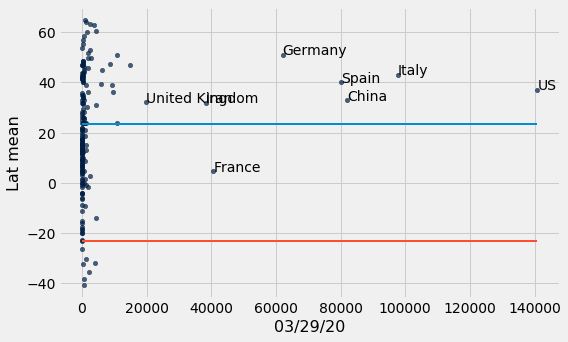

In [179]:
country_summary.where(country_summary['growth']>=0).select([last_day, 'Lat mean']).scatter(last_day, width=8)
for c in largest_cases['Country/Region']:
    label_point(c, last_day, 'Lat mean')
max_cases = max(country_summary[last_day])
plots.plot([0,max_cases], [23.5, 23.5])
plots.plot([0,max_cases], [-23.5, -23.5])

In [166]:
country_summary.where(country_summary['growth'] > 0.2)

Country/Region,Lat mean,Long mean,03/29/20,new,growth,rate,days
Angola,-11.2027,17.8739,7,2,0.285714,1.4,2
Barbados,13.1939,-59.5432,33,7,0.212121,1.26923,11
Bhutan,27.5142,90.4336,4,1,0.25,1.33333,0
Bosnia and Herzegovina,43.9159,17.6791,323,65,0.201238,1.25194,20
Cameroon,3.848,11.5021,139,48,0.345324,1.52747,13
Congo (Brazzaville),-4.0383,21.7587,19,15,0.789474,4.75,1
Cote d'Ivoire,7.54,-5.5471,165,64,0.387879,1.63366,13
Djibouti,11.8251,42.5903,18,4,0.222222,1.28571,5
El Salvador,13.7942,-88.8965,24,5,0.208333,1.26316,6
Eritrea,15.1794,39.7823,12,6,0.5,2,4


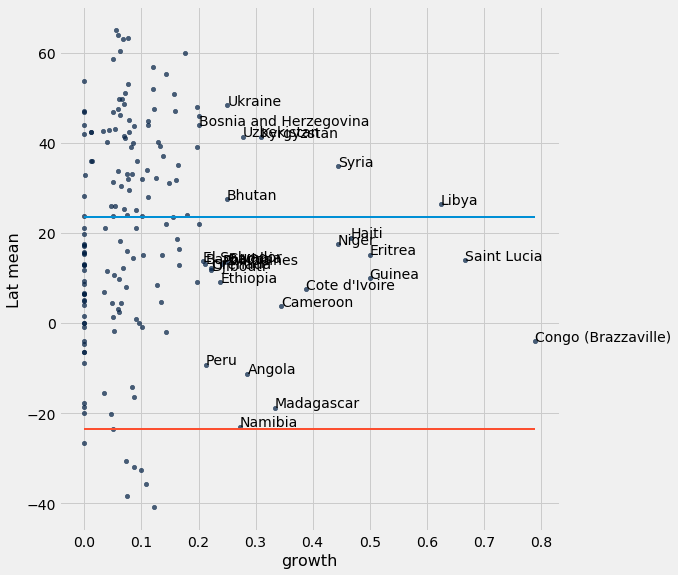

In [182]:
country_summary.where(country_summary['growth']>=0).select(['growth', 'Lat mean']).scatter('growth', width=8, height=9)
for c in country_summary.where(country_summary['growth'] > 0.2)['Country/Region']:
    label_point(c, 'growth', 'Lat mean')
max_growth = max(country_summary['growth'])
_ = plots.plot([0,max_growth], [23.5, 23.5])
_ = plots.plot([0,max_growth], [-23.5, -23.5])

### Confirmed cases in one country

In [168]:
w = widgets.Dropdown(
    options=countries_by_day.categories,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
w

Dropdown(description='Country:', index=165, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',…

In [169]:
country = w.value

In [170]:
country_trend = countries_by_day.extract(country).trend()
country_trend.following('3/11/20').show()

Day,US,new,% new,rate
03/11/20,1281,322,0.335766,1.33577
03/12/20,1663,382,0.298205,1.2982
03/13/20,2179,516,0.310283,1.31028
03/14/20,2727,548,0.251492,1.25149
03/15/20,3499,772,0.283095,1.28309
03/16/20,4632,1133,0.323807,1.32381
03/17/20,6421,1789,0.386226,1.38623
03/18/20,7783,1362,0.212116,1.21212
03/19/20,13677,5894,0.757292,1.75729
03/20/20,19100,5423,0.396505,1.39651


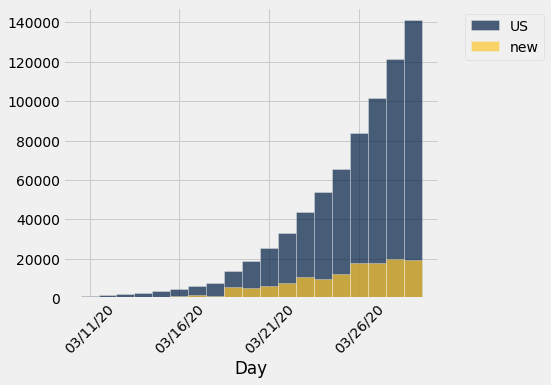

In [171]:
recent = country_trend.following('3/11/20')
recent.extract([country, 'new']).bar('Day', height=5)
_ = plots.xticks(rotation=45)

In [172]:
projection = project_trend(recent, 14)
projection.show()

Day,US,new,% new,rate
03/11/20,1281,322,0.335766,1.33577
03/12/20,1663,382,0.298205,1.2982
03/13/20,2179,516,0.310283,1.31028
03/14/20,2727,548,0.251492,1.25149
03/15/20,3499,772,0.283095,1.28309
03/16/20,4632,1133,0.323807,1.32381
03/17/20,6421,1789,0.386226,1.38623
03/18/20,7783,1362,0.212116,1.21212
03/19/20,13677,5894,0.757292,1.75729
03/20/20,19100,5423,0.396505,1.39651


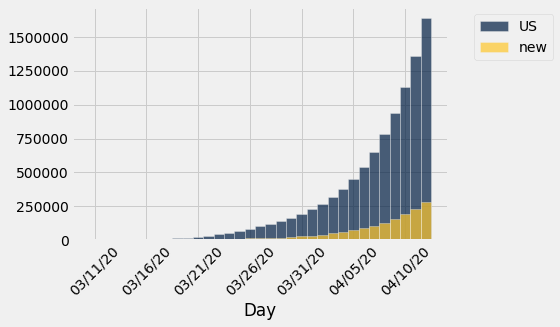

In [173]:
projection.extract([country, 'new']).bar('Day')
_ = plots.xticks(rotation=45)